In [1]:
import agent
import numpy as np
from game import Game
from collections import deque
from agent import Agent
import time
import torch
import datetime
import random
import model
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output
import pickle
import math
import os
print("Numpy version:", np.__version__)
print("PyTorch version:", torch.__version__)

Numpy version: 1.24.1
PyTorch version: 2.0.1+cpu


# Deep Q-Learning function

In [2]:
def transform_state(state, mode='plain'):
    """ Returns the (log2 / 17) of the values in the state array """
    
    if mode == 'plain':
        return np.reshape(state, -1)
    
    elif mode == 'plain_hw':
        return np.concatenate([np.reshape(state, -1), np.reshape(np.transpose(state), -1)])
    
    elif mode == 'log2':
        state = np.reshape(state, -1)
        state[state == 0] = 1
        return np.log2(state) / 17
    
    elif mode == 'one_hot':
        
        state = np.reshape(state, -1)
        state[state == 0] = 1
        state = np.log2(state)
        state = state.astype(int)
        new_state = np.reshape(np.eye(18)[state], -1)     
        return new_state
    
    elif mode == 'conv':
        X = np.reshape(state, (4,4))
        print("X")
        power_mat = np.zeros(shape=(1,4,4,16),dtype=np.float32)
        for i in range(4):
            for j in range(4):
                if(X[i][j]==0):
                    power_mat[0][i][j][0] = 1.0
                else:
                    power = int(math.log(X[i][j],2))
                    power_mat[0][i][j][power] = 1.0

        return power_mat 

    else:
        return state

def dqn(n_episodes=100, eps_start=0.05, eps_end=0.001, eps_decay=0.995, step_penalty = 0, sample_mode = 'error',
        start_learn_iterations = 20, bootstrap_iterations = 0, bootstrap_every=50):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
        step_penalty (int): if we want to deduct some points from the reward for taking a step, put it here
        sample_mode (str): how to assign sample probabilities for experiences in the replay buffer
        learn_iterations (int): number of learning iterations after each episode
        bootstrap_iterations (int): how many bootstrapping iterations to perform*
        bootstrap_every (int): how often to perform bootstrapping
        
        * bootstrapping here - episodes starting with randomly filled intermediate state boards, imitating the situation
        when the game started from the middle.
    """
    
    eps = eps_start
    starting_iteration = agent.current_iteration
    best_game_history, worst_game_history = load_game_history(version)
    learn_iterations = start_learn_iterations - (agent.current_iteration // 5000) if agent.current_iteration < start_learn_iterations * 5000 else 1
    learn_iterations = start_learn_iterations
    
    # main loop
    for i_episode in range(1, n_episodes+1):
        agent.current_iteration = agent.current_iteration + 1
        time_start = time.time()
        
        # keep track of different actions taken per episode
        actions = np.array([0, 0, 0, 0])
        
        # Starting with a fresh board
        env.reset(2, step_penalty)                        # reset environment
        
        state = transform_state(env.current_state(), mode = 'plain')   # get the current state        
        reward = env.reward                               # get the reward
        total_rewards = reward                            # initialize total rewards
        score = env.score                                 # initialize the score
        agent.total_steps = 0
        
        # keep playing
        while not env.done:
            reward = env.negative_reward

            # state_1 = transform_state(state, mode = 'conv')             
            action_values = agent.act(state)    # select an action
            
            actions_sorted = [(i, v) for i, v in enumerate(action_values[0])]
            actions_sorted = sorted(actions_sorted, key=lambda x: x[1], reverse=True)
            
            random_action = random.choice(np.arange(agent.action_size))
            action_idx = 0
            env.moved = False
            while not env.moved:
                
                if random.random() < eps:
                    action_elem = actions_sorted[random_action]
                else:
                    action_elem = actions_sorted[action_idx]
                    action_idx += 1

                action = np.int64(action_elem[0])
                actions[action] += 1
                env.step(action, action_values)                              # send the action to environment
                next_state = transform_state(env.current_state(), mode = 'plain')   # get the current state       
                
                reward = env.reward                             # get the reward

                # save the results of the step

                error = np.abs(reward - action_elem[1]) ** 2
                score = env.score
                done = env.done                             # check if episode has finished

                # learning step
                if len(agent.actions_avg_list) > 0:
                    actions_dist = [np.mean(agent.actions_deque[i]) for i in range(4)][action]
                else:
                    actions_dist = (actions / np.sum(actions))[action]

                # Save this experience
                # print("reward: ", reward)
                agent.step(state, action, reward, next_state, done, error, actions_dist) 


                state = next_state

                agent.total_steps += 1
                total_rewards += reward

                if done:
                    break 
        
        # Do the actual learning
        agent.learn(learn_iterations, mode=sample_mode, save_loss = True, weight = env.game_board.max())
        
        # Calculate action stats
        actions = actions / env.steps
        
        agent.actions_deque[0].append(actions[0])
        agent.actions_deque[1].append(actions[1])
        agent.actions_deque[2].append(actions[2])
        agent.actions_deque[3].append(actions[3])
        
        agent.actions_avg_list.append([np.mean(agent.actions_deque[i]) for i in range(4)])
        
        # Here we keep track of the learning progress and save the best values
        if total_rewards > agent.max_total_reward:
            agent.max_total_reward = total_rewards
        
        if score > agent.max_score:
            agent.max_score = score
            agent.best_score_board = env.game_board.copy()
            best_game_history = env.history.copy()
        
        if score < agent.min_score:
            agent.min_score = score
            worst_game_history = env.history.copy()
        
        if env.game_board.max() > agent.max_val:
            agent.max_val = env.game_board.max()
            agent.best_val_board = env.game_board.copy()
        
        if env.steps > agent.max_steps:
            agent.max_steps = env.steps
            agent.best_steps_board = env.game_board.copy()
            
        
        agent.total_rewards_list.append(total_rewards)
        agent.scores_list.append(score)                 # save most recent score to total
        agent.max_vals_list.append(env.game_board.max())
        agent.max_steps_list.append(env.steps)
        
        agent.last_n_scores.append(score)
        agent.last_n_steps.append(env.steps)
        agent.last_n_vals.append(env.game_board.max())
        agent.last_n_total_rewards.append(total_rewards)
        
        agent.mean_scores.append(np.mean(agent.last_n_scores))
        agent.mean_steps.append(np.mean(agent.last_n_steps))
        agent.mean_vals.append(np.mean(agent.last_n_vals))
        agent.mean_total_rewards.append(np.mean(agent.last_n_total_rewards))
        
        time_end = time.time()
        
        # ---------------------------
        # BEGIN OF BOOTSTRAPPING PART
        # ---------------------------
        if i_episode % bootstrap_every == 0:
            
            for b_episode in range(bootstrap_iterations):
                env.reset(2, step_penalty, bootstrapping=True)  # reset environment
                state = transform_state(env.current_state(), mode = 'plain')   # get the current state        
                reward = env.reward
                score = env.score
                first_step = True
                
                # keep playing while there are available moves
                while not env.done:
                    reward = env.negative_reward
            
                    action_values = agent.act(state)    # select an action

                    actions_sorted = [(i, v) for i, v in enumerate(action_values[0])]
                    actions_sorted = sorted(actions_sorted, key=lambda x: x[1], reverse=True)

                    random_action = random.choice(np.arange(agent.action_size))
                    action_idx = 0
                    while reward == env.negative_reward:
                        
                        if random.random() < eps:
                            action_elem = actions_sorted[random_action]
                        else:
                            try:
                                action_elem = actions_sorted[action_idx]
                                action_idx += 1
                            except IndexError:
                                print(action_idx)
                                
                                print(actions_sorted)
                                return

                        action = np.int64(action_elem[0])
                        actions[action] += 1
                        env.step(action, action_values)                                # send the action to environment
                        next_state = transform_state(env.current_state(), mode = 'plain')   # get the current state        
                        reward = env.reward                             # get the reward

                        # save the results of the step

                        error = np.abs(reward - action_elem[1]) ** 2
                        score = env.score
                        done = env.done                             # check if episode has finished

                        # learning step
                        if len(agent.actions_avg_list) > 0:
                            actions_dist = [np.mean(agent.actions_deque[i]) for i in range(4)][action]
                        else:
                            actions_dist = (actions / np.sum(actions))[action]

                        # Save this experience
                        agent.step(state, action, reward, next_state, done, error, actions_dist) 


                        state = next_state

                        agent.total_steps += 1
                        total_rewards += reward

                        if done:
                            break 
                
                # Perform learning
                agent.learn(learn_iterations, mode=sample_mode, save_loss = False, weight = env.game_board.max())
        
        # ---------------------------
        # END OF BOOTSTRAPPING PART
        # ---------------------------
        
        # Increasing the epsilon every N episodes in order to allow for some exploration 
        if agent.current_iteration % 5000 == 0:
            eps = eps * 2
        else:
            eps = max(eps_end, eps_decay*eps)    # decrease epsilon
        
        # Display training stats 
        if agent.current_iteration % 100 == 0:
            clear_output()
            
            # Training metrics
            fig, ax1 = plt.subplots()
            fig.set_size_inches(16,6)
            ax1.plot(agent.max_vals_list + [None for i in range(10000 - len(agent.scores_list))], label='Max cell value seen on board', alpha = 0.3, color='g')
            ax1.plot(agent.mean_steps + [None for i in range(10000 - len(agent.scores_list))], label='Mean steps over last 50 episodes', color='b')            
#             ax1.plot(agent.scores_list + [None for i in range(10000 - len(agent.scores_list))], label='Scores', color='c', alpha=0.2)            
#             ax1.plot(agent.losses, label='Loss', color='b')
#             ax1.set_yscale('log')
            
#             ax1.plot(agent.mean_scores + [None for i in range(10000 - len(agent.scores_list))], label='Mean score over last 50 episodes', color='b')

            ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
            
            ax2.plot(agent.mean_total_rewards + [None for i in range(10000 - len(agent.scores_list))], label='Mean total rewards over last 50 episodes', color='r')            
            fig.tight_layout()  # otherwise the right y-label is slightly clipped
            plt.xlabel('Episode #')
            handles, labels = [(a + b) for a, b in zip(ax1.get_legend_handles_labels(), ax2.get_legend_handles_labels())]
            plt.legend(handles, labels)
            plt.show()
            
            plt.figure(figsize=(16,6))
            plt.title('Loss')
            plt.plot(agent.losses)
            plt.yscale('log')
            plt.show()
            
            # Averaged actions stats
            plt.figure(figsize=(16,6))
            plt.title('Averaged actions distribution per game')
            a_list = np.array(agent.actions_avg_list).T
            
            plt.stackplot([i for i in range(1, len(agent.actions_avg_list)+1)], a_list[0], a_list[1], a_list[2], a_list[3], labels=['Up %0.2f' % (agent.actions_avg_list[-1][0] * 100), 'Down %0.2f' % (agent.actions_avg_list[-1][1] * 100), 'Left %0.2f' % (agent.actions_avg_list[-1][2] * 100), 'Right %0.2f' % (agent.actions_avg_list[-1][3] * 100)] )
            plt.legend()
            plt.show()

                
            
            # Display the board with the best score
            env.draw_board(agent.best_score_board, 'Best score board')
            
            # Save the model and the game history
            save_state(version, eps)
            save_game_history(version, best_game_history, worst_game_history)
            
        s = '%d/%d | %0.2fs | Sc:%d | AvgSc:%d | TR:%.1f | AvgTR:%.1f | GlMaxVal:%d | Epsilon:%.4f' %\
              (agent.current_iteration, starting_iteration + n_episodes, time_end - time_start, score, np.mean(agent.last_n_scores), total_rewards, np.mean(agent.last_n_total_rewards), np.max(agent.max_vals_list), eps)
        
        s = s + ' ' * (120-len(s))
        print(s, end='\r')

        

In [3]:
base_dir = './data/'

def save_state(name, eps):
    with open(base_dir+'/game_%s.pkl' % name, 'wb') as f:
        state = {
            'env': env,
            'last_eps': eps
        }
        pickle.dump(state, f)
    agent.save(name)
    

def save_game_history(name, best_history, worst_history):
    with open(base_dir+'/best_game_history_%s.pkl' % name, 'wb') as f:
        pickle.dump(best_history, f)
    with open(base_dir+'/worst_game_history_%s.pkl' % name, 'wb') as f:
        pickle.dump(worst_history, f)
    
def load_game_history(name):
    best_history = []
    worst_history = []
    if os.path.exists(base_dir+'/best_game_history_%s.pkl' % name):
        with open(base_dir+'/best_game_history_%s.pkl' % name, 'rb') as f:
            best_history = pickle.load(f)
    
    if os.path.exists(base_dir+'/worst_game_history_%s.pkl' % name):
        with open(base_dir+'/worst_game_history_%s.pkl' % name, 'rb') as f:
            worst_history = pickle.load(f)
    
    return best_history, worst_history
    
def load_state(name):
    with open(base_dir+'/game_%s.pkl' % name, 'rb') as f:
        state = pickle.load(f)
        g = state['env']
        eps = state['last_eps']
    a = Agent(state_size=4 * 4 * 18, fc1_units=1024, fc2_units=1024, fc3_units = 1024)
    a.load(name)
    return g, a, eps

# Initialization & training

In [4]:
version = 'ohe_2_steps_move_penalty_log_reward_512_3_layers_random'
# env, agent, eps = load_state(version)

# Create the environment with 4x4 board
env = Game(4, reward_mode='log2', negative_reward = 0, cell_move_penalty = 0)
eps = 0.5
# Create the agent, duplicating default values for visibility
agent = Agent(state_size=4*4, action_size=env.action_size,
              seed=42, buffer_size = 100000, batch_size = 512, lr = 0.005, use_expected_rewards=False, predict_steps = 2,
             gamma = 0.9, tau = 0.001)

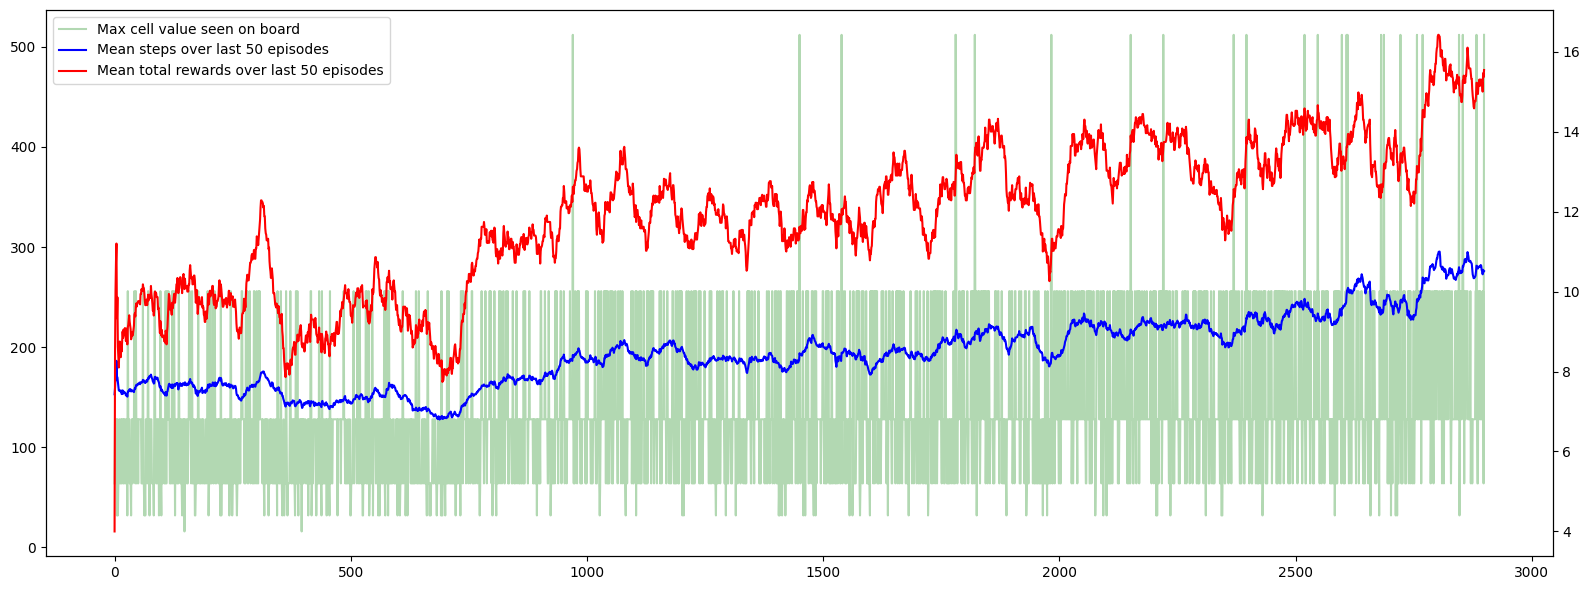

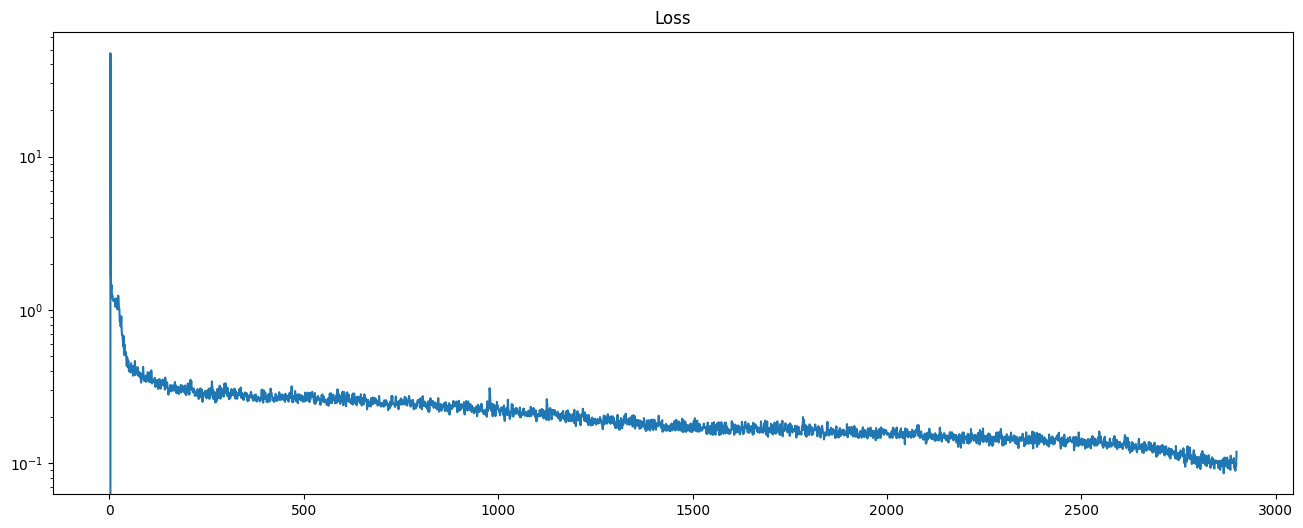

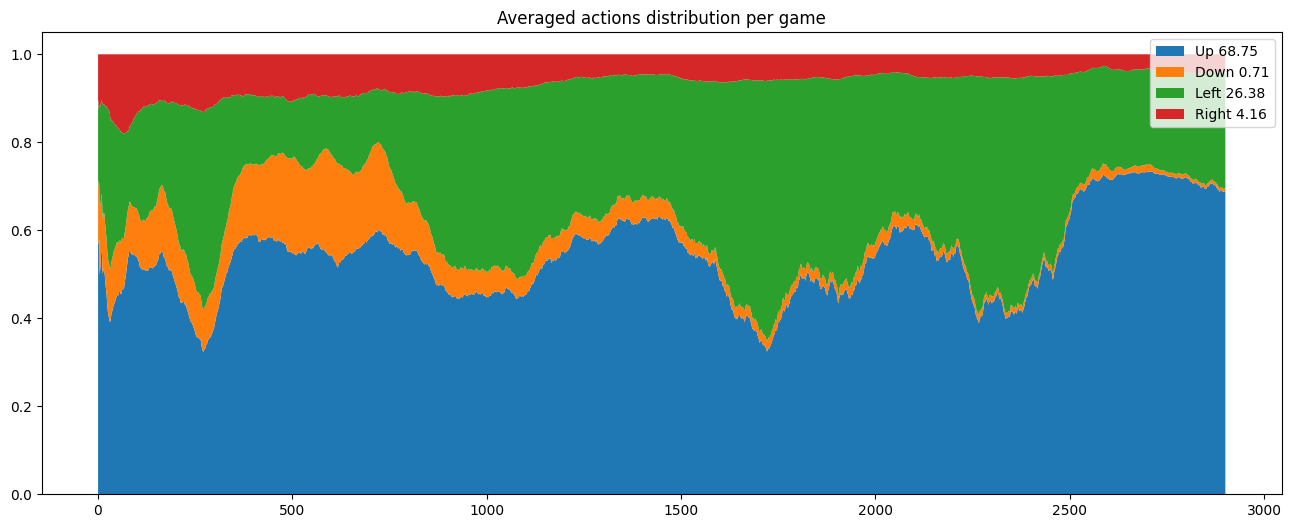

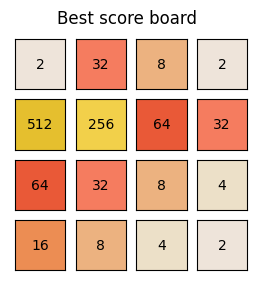

In [6]:
# Run the training
dqn(n_episodes=100000, 
    eps_start=eps or 0.05, 
    eps_end=0.00001, 
    eps_decay=0.999,
    step_penalty = 0, 
    sample_mode = 'random',
    start_learn_iterations = 10, 
    bootstrap_iterations = 0, 
    bootstrap_every=50)